In [601]:
import sys
sys.path.append('../../')

from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils,
    constants,
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import signal
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.graphics.gofplots import qqplot
from scipy import ndimage as ndi
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)
reload(utils)
reload(constants)

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [5]:
def make_exp_xarray(imgs, exp_id, imaging_scheme):
    lambdas_counts = pio.process_imaging_scheme_str(imaging_sscheme, "/")
    lambdas = np.array([l[0] for l in lambdas_counts])
    pairs = [l[1] for l in lambdas_counts]
    unique_lambdas = [lambdas[idx] for idx in sorted(np.unique(lambdas, return_index=True)[1])]
    n_animals = imgs.shape[0] // len(lambdas)
    img_height, img_width = imgs.shape[1], imgs.shape[2]
    
    tmp_img_stack = np.reshape()

In [6]:
meta_dir = Path('/Users/sean/code/pharynx_redox/data/paired_ratio')

all_ims_path = meta_dir.joinpath('all_seg_imgs.nc')

# LOAD / EXTRACT RAW IMAGESM
try:
    all_ims = xr.load_dataarray(all_ims_path)
except FileNotFoundError:
    all_ims = []
    for exp_dir in sorted(meta_dir.iterdir()):
        if not exp_dir.is_dir():
            continue
        logging.info(f'loading {exp_dir.stem}')
        img_path = list(exp_dir.glob('*.tif*'))[0]
        strain_map_path = list(exp_dir.glob('*-indexer.csv'))[0]
        strain_map = pio.load_strain_map_from_disk(strain_map_path)
        imgs = pio.load_images(img_path, "TL/470/410/470/410", strain_map)

        # set experiment-id to be the "strain"
        imgs['strain'] = np.repeat(exp_dir.stem, imgs.strain.shape[0])
    #     imgs = imgs.rename({'strain': 'experiment'})
        all_ims.append(imgs)

    all_ims = xr.concat(all_ims, 'strain')
    all_ims.to_netcdf('/Users/sean/code/pharynx_redox/data/paired_ratio/all_raw_imgs.nc')

# LOAD / CREATE SEGMENTED IMAGES
seg_imgs_path = meta_dir.joinpath('all_seg_imgs.nc')
try:
    all_seg_ims = xr.load_dataarray(seg_imgs_path)
except FileNotFoundError:        
    all_seg_ims = ip.segment_pharynxes(all_ims)
    all_seg_ims.to_netcdf(seg_imgs_path)

# LOAD / CREATE ROT-FL IMAGES    
rot_fl_path = meta_dir.joinpath('all_rot_fl.nc')
rot_seg_path = meta_dir.joinpath('all_rot_seg.nc')
try:
    all_rot_fl = xr.load_dataarray(rot_fl_path)
    all_rot_seg = xr.load_dataarray(rot_seg_path)
except:
    all_rot_fl, all_rot_seg = ip.center_and_rotate_pharynxes(all_ims, all_seg_ims)

    all_rot_fl.to_netcdf(rot_fl_path)
    all_rot_seg.to_netcdf(rot_seg_path)

midlines = ip.calculate_midlines(all_rot_seg)

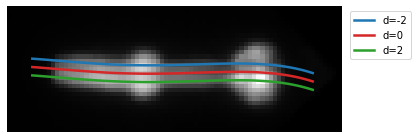

In [10]:
img_idx = 0
pair = 0
wvl = '410'
m_xs, m_ys = midlines[img_idx][wvl][pair].linspace()

# plt.figure(figsize=(20,10))

plt.imshow(all_rot_fl.sel(wavelength=wvl, pair=pair)[img_idx], cmap='gray')

lw = 2.5
plt.plot(m_xs, m_ys+2, label='d=-2', linewidth=lw);
plt.plot(m_xs, m_ys, label='d=0', color='tab:red', linewidth=lw);
plt.plot(m_xs, m_ys-2, label='d=2', color='tab:green', linewidth=lw);

plt.ylim(50,80);
plt.xlim(45, 125);
plt.axis('off');
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/dY_shift.pdf', dpi=1200);
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/dY_shift.png', dpi=300);

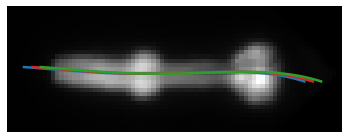

In [359]:
img_idx = 0
pair = 0
wvl = '410'
m_xs, m_ys = midlines[img_idx][wvl][pair].linspace()

# plt.figure(figsize=(20,10))

plt.imshow(all_rot_fl.sel(wavelength=wvl, pair=pair)[img_idx], cmap='gray')

lw = 2.5
plt.plot(m_xs-2, m_ys, label='dX=-2', linewidth=lw);
plt.plot(m_xs, m_ys, label='dX=0', color='tab:red', linewidth=lw);
plt.plot(m_xs+2, m_ys, label='dX=2', color='tab:green', linewidth=lw);

plt.ylim(50,80);
plt.xlim(45, 125);
plt.axis('off');
# plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/dX_shift.pdf', dpi=1200);
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/dX_shift.png', dpi=300);

# Do the Shifting

In [486]:
ref_wvl = '410'
n_points = 150
resample_points = 600

shifts = np.arange(-3, 3.5, .5)

shift_data = xr.DataArray(
    0.,
    coords={
        'strain': all_rot_fl.strain.values,
        'pair': [0, 1],
        'wavelength': ['410', '470', 'r'],
        'shift': shifts,
        'direction': ['x', 'y'],
        'position': np.arange(resample_points)
    },
    dims=['strain', 'pair', 'wavelength', 'shift', 'direction', 'position']
)

for pair in tqdm_notebook(range(all_rot_fl.pair.size), desc='pair'):
    for shift in tqdm_notebook(shifts, leave=False, desc='shift'):
        for direction in tqdm_notebook(['x', 'y'], leave=False, desc='direction'):
            i410_ = np.zeros((all_rot_fl.strain.size,n_points), dtype=all_rot_fl.dtype)
            i470_ = i410_.copy()

            for img_idx in tqdm_notebook(range(all_rot_fl.strain.size), leave=False):
#             for img_idx in tqdm_notebook(range(10), leave=False):
                if direction == 'x':
                    dx, dy = (shift, 0)
                if direction == 'y':
                    dx, dy = (0, shift)

                # Select Image
                m_xs, m_ys = midlines[img_idx]['410'][pair].linspace(n=n_points)
                im410 = all_rot_fl.sel(wavelength='410', pair=pair)[img_idx]
                im470 = all_rot_fl.sel(wavelength='410', pair=pair)[img_idx]

                # Measure under midline
                i410_[img_idx, :] = ndi.map_coordinates(im410, np.stack([m_ys, m_xs]), order=1)
                i470_[img_idx, :] = ndi.map_coordinates(im470, np.stack([m_ys + dy, m_xs + dx]), order=1)

            # smooth
            new_xs = np.linspace(0, 1, resample_points)

            # Resample
            i410_sm = np.squeeze(profile_processing.smooth_profile_data(i410_)[0](new_xs))
            i470_sm = np.squeeze(profile_processing.smooth_profile_data(i470_)[0](new_xs))

            # Re-save
            shift_data.loc[dict(pair=pair, wavelength='410', shift=shift, direction=direction)] = i410_sm
            shift_data.loc[dict(pair=pair, wavelength='470', shift=shift, direction=direction)] = i470_sm
            shift_data.loc[dict(pair=pair, wavelength='r', shift=shift, direction=direction)] = i410_sm / i470_sm

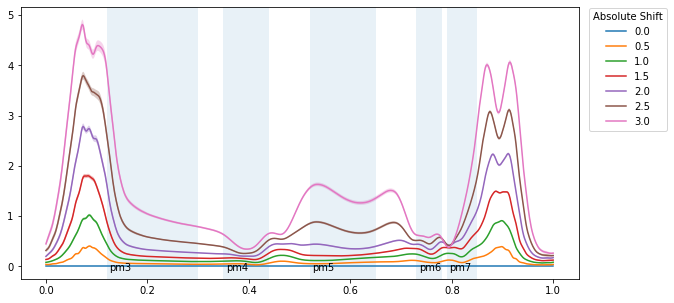

In [488]:
fig, ax = plt.subplots(figsize=(10,5))

for shift in np.unique(np.abs(shifts)):
    rr_neg = da.fold_error_pairs(
        shift_data.sel(shift=-shift, wavelength='r'),
        shift_data.sel(shift=0, wavelength='r')
    )
    rr_pos = da.fold_error_pairs(
        shift_data.sel(shift=shift, wavelength='r'),
        shift_data.sel(shift=0, wavelength='r')
    )
    
    max_rr = xr.ufuncs.maximum(rr_pos, rr_neg).max(dim='direction').mean(dim='pair')
    
    plots.plot_profile_avg_with_bounds(data=max_rr, ax=ax, xs=new_xs, label=shift, confint_alpha=0.05)
    
plots.add_regions_to_axis(ax=ax, regions=constants.untrimmed_regions)
plt.legend(bbox_to_anchor=(1.01,1.015), loc="upper left", title='Absolute Shift');

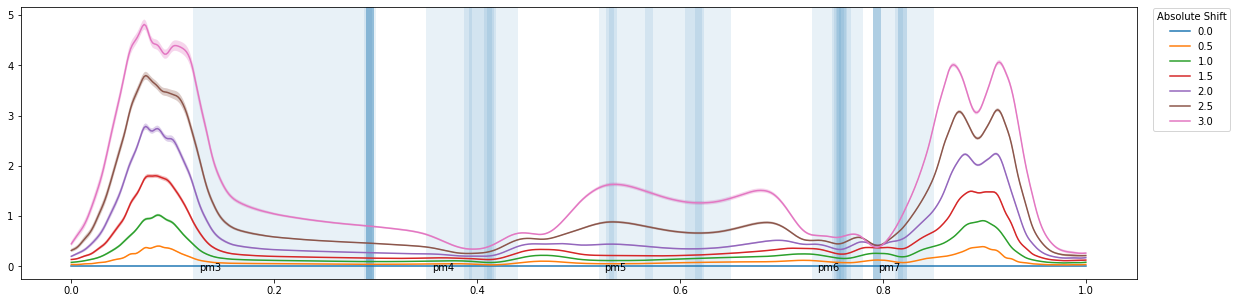

In [489]:
fig, ax = plt.subplots(figsize=(20,5))

for shift in np.unique(np.abs(shifts)):
    rr_neg = da.fold_error_pairs(
        shift_data.sel(shift=-shift, wavelength='r'),
        shift_data.sel(shift=0, wavelength='r')
    )
    rr_pos = da.fold_error_pairs(
        shift_data.sel(shift=shift, wavelength='r'),
        shift_data.sel(shift=0, wavelength='r')
    )
    
    max_rr = xr.ufuncs.maximum(rr_pos, rr_neg).max(dim='direction').mean(dim='pair')
    opt_regions = profile_processing.find_optimal_regions(
        constants.untrimmed_regions, max_rr, min_width=5, rescale_regions=True
    )
    opt_regions = {k: v/600 for k, v in opt_regions.items()}
    
    if shift != 0:
        plots.add_regions_to_axis(ax=ax, regions=opt_regions, hide_labels=True)
    plots.plot_profile_avg_with_bounds(data=max_rr, ax=ax, xs=new_xs, label=shift, confint_alpha=0.05)
    
plots.add_regions_to_axis(ax=ax, regions=constants.untrimmed_regions)
plt.legend(bbox_to_anchor=(1.01,1.015), loc="upper left", title='Absolute Shift');
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/shift_regions_new.pdf')

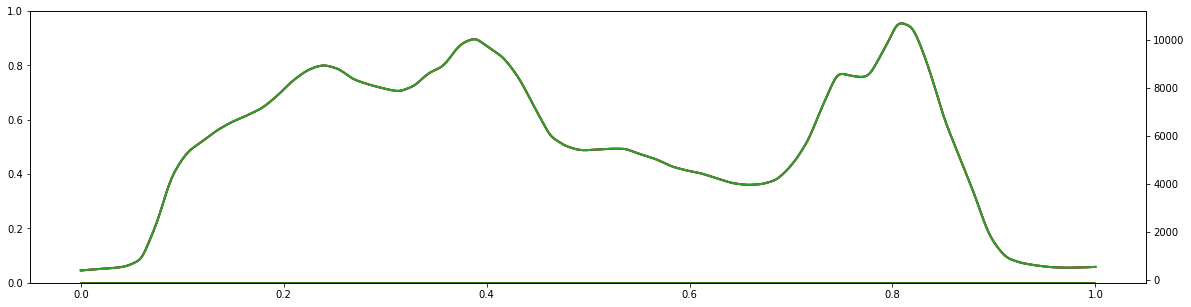

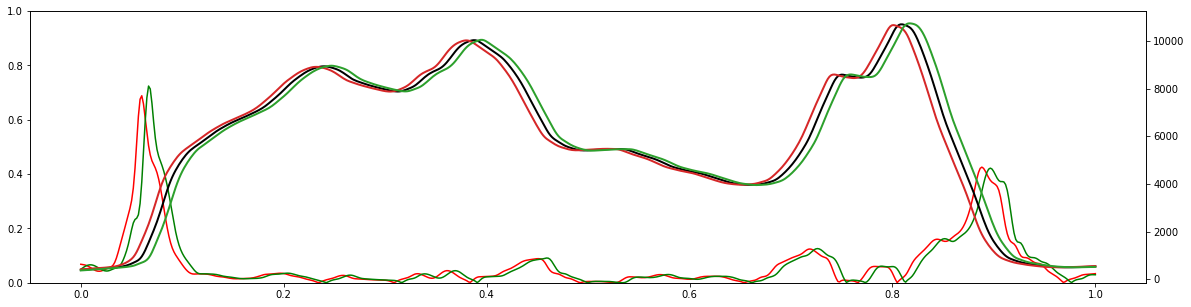

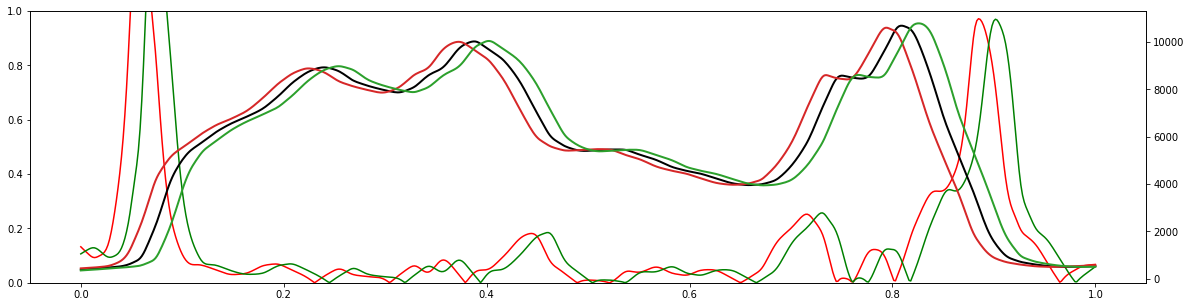

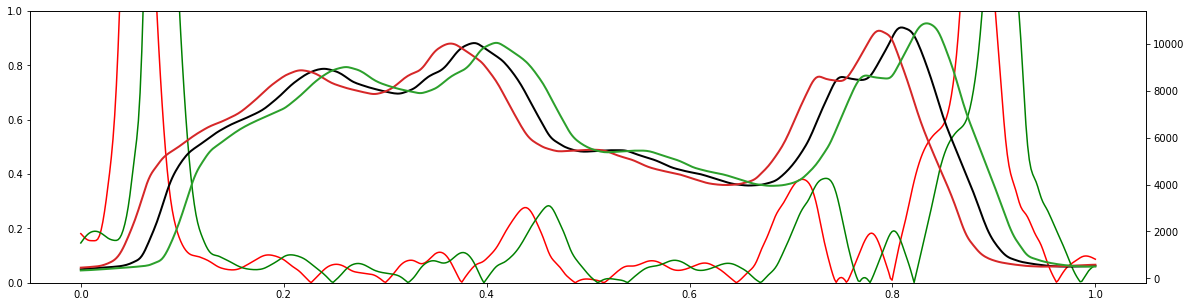

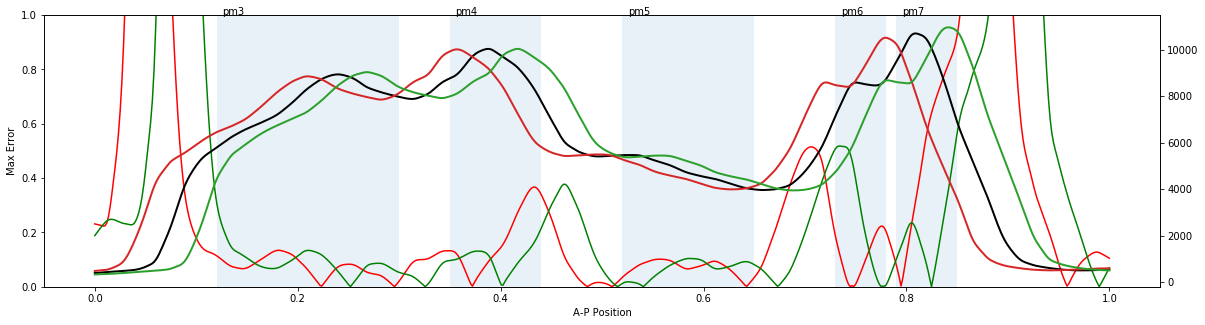

In [471]:
reload(plots);
reload(da);
# fig, ax = plt.subplots(figsize=(14,7))all_ims

# Set up Colormap
norm = mpl.colors.Normalize(vmin=0, vmax=2)
newcmp = ListedColormap(cm.plasma(np.linspace(0, 0.8, 256)))
m = cm.ScalarMappable(norm=norm, cmap=newcmp)
i=0
# Plot actual data
xs = np.linspace(0, 1, shift_data.position.size)
for shift in np.unique(np.abs(shifts)):

    rr_neg = da.fold_error_pairs(
        shift_data.sel(shift=-shift, wavelength='r'),
        shift_data.sel(shift=0, wavelength='r')
    )
    rr_pos = da.fold_error_pairs(
        shift_data.sel(shift=shift, wavelength='r'),
        shift_data.sel(shift=0, wavelength='r')
    )
    
    max_rr = xr.ufuncs.maximum(rr_pos, rr_neg).max(dim='direction')
    
    fig, ax = plt.subplots(figsize=(20,5))
    
    ax.plot(xs,
        rr_pos.sel(direction='x', pair=0)[i],
        label=shift,
        color='red'
    )
    
    ax.plot(xs,
        rr_neg.sel(direction='x', pair=0)[i],
        label=shift,
        color='green'
    )
    
    ax2 = plt.twinx();
    ax2.plot(xs, shift_data.sel(shift=0, wavelength='410', pair=0, direction='x')[i], color='k', linewidth=2)
    ax2.plot(xs, shift_data.sel(shift=shift, wavelength='470', pair=0, direction='x')[i], color='tab:red', linewidth=2)
    ax2.plot(xs, shift_data.sel(shift=-shift, wavelength='470', pair=0, direction='x')[i], color='tab:green', linewidth=2)
    
    ax.set_ylim(0,1)
plots.add_regions_to_axis(ax, regions=constants.untrimmed_regions, label_dist_bottom_percent=1)



# Configure Plot
ax.set_ylabel('Max Error');
ax.set_xlabel('A-P Position');
# plt.legend(bbox_to_anchor=(1.01,1.015), loc="upper left", title='Absolute Shift');

# Plot

In [449]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)

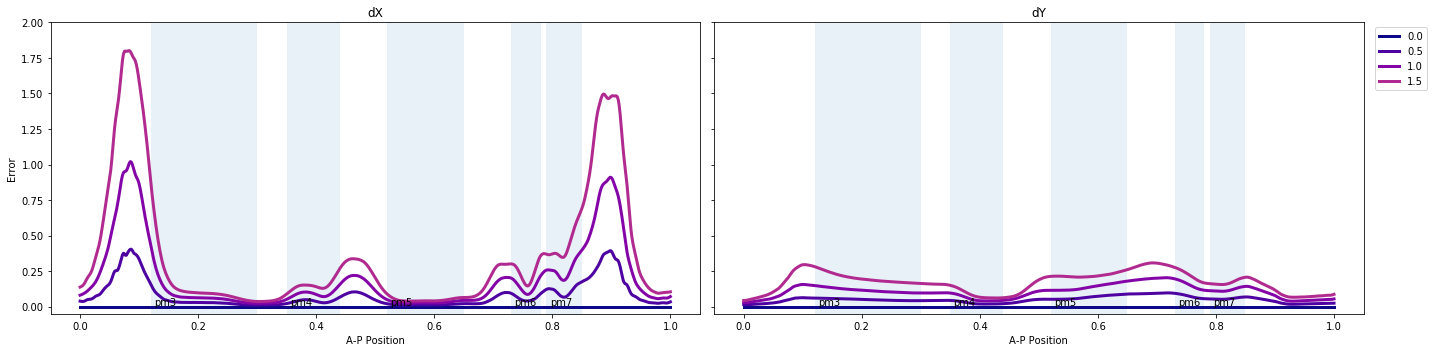

In [496]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
lw = 3

import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap


norm = mpl.colors.Normalize(vmin=0, vmax=3)
newcmp = ListedColormap(cm.plasma(np.linspace(0, 0.8, 256)))
m = cm.ScalarMappable(norm=norm, cmap=newcmp)

xs = np.linspace(0, 1, shift_data.position.size)


for shift in np.unique(np.abs(shifts)):
    if shift >= 2:
        continue
    rr_neg = da.fold_error_pairs(
        shift_data.sel(shift=-shift, wavelength='r'),
        shift_data.sel(shift=0, wavelength='r')
    )
    rr_pos = da.fold_error_pairs(
        shift_data.sel(shift=shift, wavelength='r'),
        shift_data.sel(shift=0, wavelength='r')
    )
    
    max_rr = xr.ufuncs.maximum(rr_pos, rr_neg).mean(dim=['pair', 'strain'])
    
    axes[0].plot(xs, max_rr.sel(direction='x'), label=shift, linewidth=lw, color=m.to_rgba(shift))
    axes[1].plot(xs, max_rr.sel(direction='y'), label=shift, linewidth=lw, color=m.to_rgba(shift))

# for shift in np.unique(shift_data.dx):
#     data = shift_data.sel(dx=shift, dy=0, wavelength='r').mean(dim=['experiment', 'pair'])
#     color = m.to_rgba(np.abs(shift))
#     if shift < 0:
#         color = mpl.colors.hsv_to_rgb(
#             mpl.colors.rgb_to_hsv(
#                 color[:-1]
#             ) * [1, 1, .9]
#         )
#     axes[0].plot(
#         xs, np.abs(1-data), label='{0:.2g}'.format(shift), linewidth=lw,
#         color=color
#     )

# for shift in np.unique(shift_data.dy):
#     data = shift_data.sel(dy=shift, dx=0, wavelength='r').mean(dim=['experiment', 'pair'])
#     axes[1].plot(
#         xs, np.abs(1-data), label='{0:.2g}'.format(shift), linewidth=lw,
#         color=m.to_rgba(np.abs(shift))
#     )

# axes[0].set_ylim(-0.25, 2.35)
axes[1].set_ylim(-0.05, 2)
axes[0].set_ylabel('Error')
axes[0].set_xlabel('A-P Position')
axes[1].set_xlabel('A-P Position')
axes[0].set_title('dX')
axes[1].set_title('dY')

plots.add_regions_to_axis(ax=axes[0],regions=constants.untrimmed_regions)
plots.add_regions_to_axis(ax=axes[1],regions=constants.untrimmed_regions)
    
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.tight_layout()
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/shift_ratios_direction.pdf', dpi=1200);
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/shift_ratios_direction.png', dpi=300);

# Analyze effect on error for natural data

In [603]:
prof_raw = da.load_all_cached_profile_data(Path('/Users/sean/code/pharynx_redox/data/paired_ratio/'), '**/*new_idx/*.nc')
# prof_reg = da.load_all_cached_profile_data(Path('/Users/sean/code/pharynx_redox/data/paired_ratio/'), '**/*matlab_reg/*-trimmed*.nc')
mvmt = da.load_all_movement(Path('/Users/sean/code/pharynx_redox/data/paired_ratio/'))

m_0_0, m_0_1, m_1_0, m_1_1 = da.split_by_movement_types(da.mvmt_long_to_wide(mvmt), 'anterior')
stationary_idx = m_0_0.reset_index().index.values
moving_idx = np.concatenate([m_0_1.reset_index().index.values, m_1_0.reset_index().index.values])

In [632]:
err_raw

<xarray.DataArray (spec: 1726, position: 300)>
array([[0.0461559 , 0.04040619, 0.03692304, ..., 0.0561459 , 0.0558021 ,
        0.0558021 ],
       [0.04432575, 0.03836261, 0.03421207, ..., 0.04682374, 0.04674381,
        0.04674381],
       [0.12650608, 0.11927683, 0.11230089, ..., 0.02335409, 0.0224097 ,
        0.0224097 ],
       ...,
       [0.01883732, 0.01467855, 0.00512577, ...,        nan,        nan,
               nan],
       [0.01611736, 0.00873702, 0.01542353, ...,        nan,        nan,
               nan],
       [0.01058462, 0.00255336, 0.02440052, ...,        nan,        nan,
               nan]])
Coordinates:
  * position    (position) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
    wavelength  <U1 'r'
  * spec        (spec) MultiIndex
  - experiment  (spec) object '2017_02_22-HD233_SAY47' ... '2019_04_03-ASI_ablation'
  - strain      (spec) object 'HD233' 'HD233' 'HD233' ... 'SAY195' 'SAY195'
  - animal      (spec) int64 0 1 2 3 4 5 6 7 ... 115 116 117 11

In [631]:
err_raw.sel(spec=wide_mvmt[s==0].index)

ValueError: Reindexing only valid with uniquely valued Index objects

In [615]:
wide_mvmt = da.mvmt_long_to_wide(mvmt)
s = df.sum(axis=1)
wide_mvmt[s==0].index

MultiIndex([( '2017_02_22-HD233_SAY47',   0),
            ( '2017_02_22-HD233_SAY47',   2),
            ( '2017_02_22-HD233_SAY47',   3),
            ( '2017_02_22-HD233_SAY47',   4),
            ( '2017_02_22-HD233_SAY47',   7),
            ( '2017_02_22-HD233_SAY47',   8),
            ( '2017_02_22-HD233_SAY47',   9),
            ( '2017_02_22-HD233_SAY47',  13),
            ( '2017_02_22-HD233_SAY47',  14),
            ( '2017_02_22-HD233_SAY47',  15),
            ...
            ('2019_04_03_ASI_ablation', 108),
            ('2019_04_03_ASI_ablation', 109),
            ('2019_04_03_ASI_ablation', 110),
            ('2019_04_03_ASI_ablation', 112),
            ('2019_04_03_ASI_ablation', 115),
            ('2019_04_03_ASI_ablation', 117),
            ('2019_04_03_ASI_ablation', 118),
            ('2019_04_03_ASI_ablation', 119),
            ('2019_04_03_ASI_ablation', 120),
            ('2019_04_03_ASI_ablation', 121)],
           names=['experiment', 'animal'], length=614)

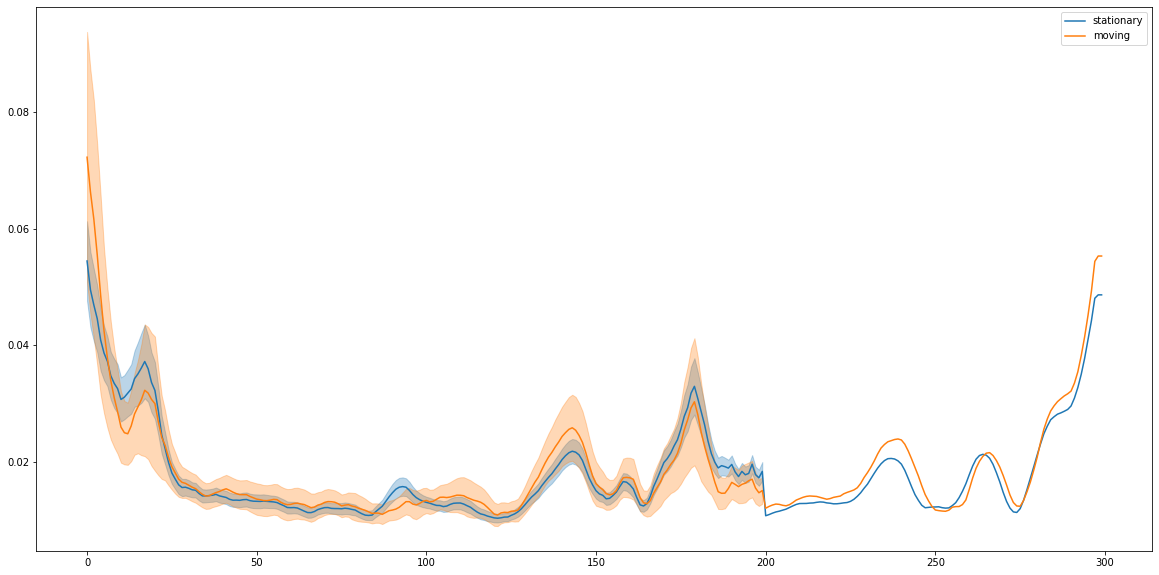

In [609]:
reload(da);
df = da.mvmt_long_to_wide(mvmt).drop([('movement', 'sides_of_tip'), ('movement', 'tip')], axis=1)['movement']
s = df.sum(axis=1)
stationary_idx = s[s==0].reset_index().index.values
moving_idx = s[s>=2].reset_index().index.values

err_raw = da.fold_error(prof_raw)
err_reg = da.fold_error(prof_reg)

fig, ax = plt.subplots(figsize=(20,10))
plots.plot_profile_avg_with_bounds(err_raw[stationary_idx], ax=ax, label='stationary', color='tab:blue')
plots.plot_profile_avg_with_bounds(err_raw[moving_idx], ax=ax, label='moving', color='tab:orange')

# plots.plot_profile_avg_with_bounds(err_reg[stationary_idx], ax=ax, label='reg stationary', color='tab:blue', linestyle='--')
# plots.plot_profile_avg_with_bounds(err_reg[moving_idx], ax=ax, label='reg moving', color='tab:orange', linestyle='--')


plt.legend();
# plt.ylim(0, 0.03);

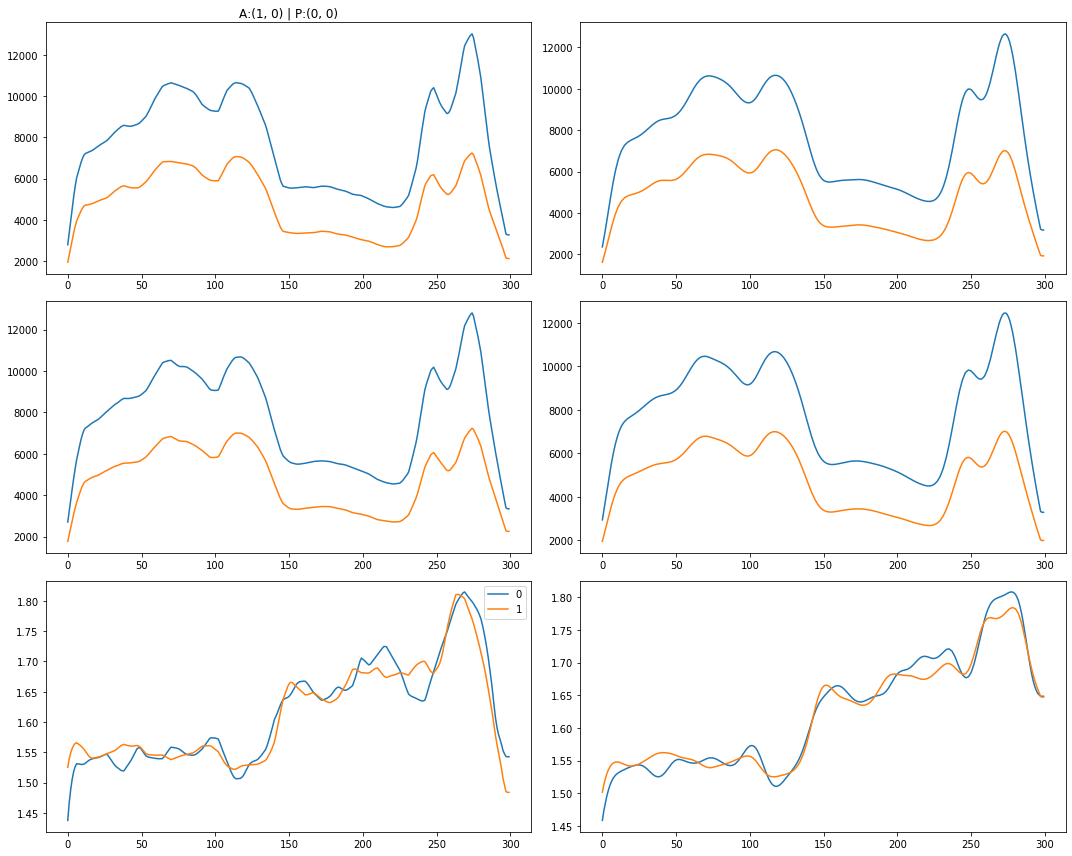

In [599]:
fig, axes = plt.subplots(3,2, figsize=(15, 12))

i= i + 1

# RAW
ax = axes[0,0]
ax.plot(prof_raw.sel(wavelength='410', pair=0)[i])
ax.plot(prof_raw.sel(wavelength='470', pair=0)[i])

ax = axes[1,0]
ax.plot(prof_raw.sel(wavelength='410', pair=1)[i])
ax.plot(prof_raw.sel(wavelength='470', pair=1)[i])

ax = axes[2,0]
ax.plot(prof_raw.sel(wavelength='r', pair=0)[i], label=0)
ax.plot(prof_raw.sel(wavelength='r', pair=1)[i], label=1)
ax.legend();

# REG
ax = axes[0,1]
ax.plot(prof_reg.sel(wavelength='410', pair=0)[i])
ax.plot(prof_reg.sel(wavelength='470', pair=0)[i])

ax = axes[1,1]
ax.plot(prof_reg.sel(wavelength='410', pair=1)[i])
ax.plot(prof_reg.sel(wavelength='470', pair=1)[i])

ax = axes[2,1]
ax.plot(prof_reg.sel(wavelength='r', pair=0)[i])
ax.plot(prof_reg.sel(wavelength='r', pair=1)[i])
axes[0,0].set_title('A:({}, {}) | P:({}, {})'.format(*tuple(df.iloc[i])));
plt.tight_layout();


# df